In [2]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
import os
os.getcwd()

train = pd.read_csv('./credit/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 

test = pd.read_csv('./credit/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submission = pd.read_csv('./credit/sample_submission.csv')

In [4]:
data=pd.concat([train, test], axis=0)
data.shape
display(data['DAYS_BIRTH'])
display(data['begin_month'])

0      -13899
1      -11380
2      -19087
3      -15088
4      -15037
        ...  
9995   -18593
9996   -10886
9997   -21016
9998   -16541
9999    -9154
Name: DAYS_BIRTH, Length: 36457, dtype: int64

0       -6.0
1       -5.0
2      -22.0
3      -37.0
4      -26.0
        ... 
9995   -19.0
9996   -34.0
9997   -55.0
9998   -33.0
9999   -11.0
Name: begin_month, Length: 36457, dtype: float64

In [5]:
def days_to_age(x):
    return (x*-1)/365
data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
display(data['DAYS_BIRTH'])

0       38.079452
1       31.178082
2       52.293151
3       41.336986
4       41.197260
          ...    
9995    50.939726
9996    29.824658
9997    57.578082
9998    45.317808
9999    25.079452
Name: DAYS_BIRTH, Length: 36457, dtype: float64

In [6]:
def minus(x):
    return x * -1
data['begin_month'] = data['begin_month'].apply(minus)
display(data['begin_month'])

0        6.0
1        5.0
2       22.0
3       37.0
4       26.0
        ... 
9995    19.0
9996    34.0
9997    55.0
9998    33.0
9999    11.0
Name: begin_month, Length: 36457, dtype: float64

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

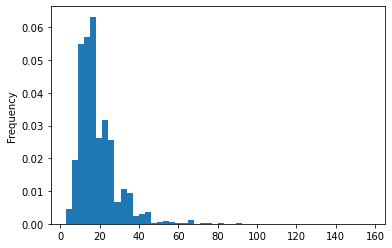

In [7]:
# 일한 일 수는 0이상일 수 없다.
data.loc[(data.DAYS_EMPLOYED)>=0,'DAYS_EMPLOYED'] = 0

# 년도로 변환
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)

# 아이가 2명 이상인 데이터는 2로 변경
# 값을 바꿀수있는 부분
data.loc[data['child_num'] >= 2,'child_num']=2


data['income_total'] = data['income_total'].astype(object)

# 정규화 
# log , 나눔
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [8]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=[int(i) for i in range(7) ]
display(data['income_total'])
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
display(data['income_total'])

0       20.25
1       24.75
2        45.0
3       20.25
4       15.75
        ...  
9995    20.25
9996    20.25
9997    29.25
9998     18.0
9999     27.0
Name: income_total, Length: 36457, dtype: object

0       0
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: income_total, Length: 36457, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

In [8]:
# 소유 여부 0 , 1로 변환

data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')


gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


In [9]:
# 범주형 변수들 LabelEncoding

from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  int64  
 1   car            36457 non-null  int64  
 2   reality        36457 non-null  int64  
 3   child_num      36457 non-null  int64  
 4   income_total   36457 non-null  int64  
 5   income_type    36457 non-null  int32  
 6   edu_type       36457 non-null  int32  
 7   family_type    36457 non-null  int32  
 8   house_type     36457 non-null  int32  
 9   DAYS_BIRTH     36457 non-null  float64
 10  DAYS_EMPLOYED  36457 non-null  float64
 11  FLAG_MOBIL     36457 non-null  int64  
 12  work_phone     36457 non-null  int64  
 13  phone          36457 non-null  int64  
 14  email          36457 non-null  int64  
 15  occyp_type     36457 non-null  int32  
 16  family_size    36457 non-null  float64
 17  begin_month    36457 non-null  float64
 18  credit 

In [16]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
display(train_x)
display(train_y)

test_x=test.drop('credit', axis=1)
#test_y=test[['credit']]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,F,N,N,0,0,Commercial associate,Higher education,Married,Municipal apartment,38.079452,12.901370,1,0,0,0,NAN,2.0,6.0
1,F,N,Y,1,0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.178082,4.219178,1,0,0,1,Laborers,3.0,5.0
2,M,Y,Y,0,1,Working,Higher education,Married,House / apartment,52.293151,12.147945,1,0,1,0,Managers,2.0,22.0
3,F,N,Y,0,0,Commercial associate,Secondary / secondary special,Married,House / apartment,41.336986,5.731507,1,0,1,0,Sales staff,2.0,37.0
4,F,Y,Y,0,0,State servant,Higher education,Married,House / apartment,41.197260,5.767123,1,0,0,0,Managers,2.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,0,State servant,Secondary / secondary special,Married,House / apartment,33.093151,5.435616,1,0,0,0,Core staff,4.0,2.0
26453,F,N,Y,1,0,Working,Higher education,Separated,House / apartment,41.893151,6.780822,1,0,0,0,NAN,2.0,47.0
26454,F,Y,N,0,1,Working,Secondary / secondary special,Civil marriage,With parents,27.621918,5.520548,1,0,0,0,Core staff,2.0,25.0
26455,M,N,Y,0,0,Working,Incomplete higher,Single / not married,House / apartment,27.794521,0.293151,1,0,0,0,Laborers,1.0,59.0


,credit
0,1.0
1,1.0
2,2.0
3,0.0
4,2.0
...,...
26452,1.0
26453,2.0
26454,2.0
26455,2.0


In [20]:
# random sampling

np.random.seed(42)

if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

display(train_indices)
display(valid_indices)

Int64Index([    0,     2,     3,     4,     5,     6,     8,     9,    10,
               13,
            ...
            26443, 26446, 26447, 26448, 26450, 26451, 26453, 26454, 26455,
            26456],
           dtype='int64', length=21162)

Int64Index([    1,     7,    11,    12,    33,    34,    35,    43,    50,
               52,
            ...
            26419, 26424, 26427, 26434, 26436, 26440, 26444, 26445, 26449,
            26452],
           dtype='int64', length=5295)

In [30]:
# nunique 열 기준 고유 관측치 값의 개수
nunique = train.nunique()
types = train.dtypes
print(nunique)
print(types)

train_x = train_x.astype({'income_total':np.float})

# category 쪽에서 문제
categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    print(col)
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_X[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
        test.fillna(training_mean, inplace=True)


gender              2
car                 2
reality             2
child_num           3
income_total        7
income_type         5
edu_type            5
family_type         5
house_type          6
DAYS_BIRTH       6621
DAYS_EMPLOYED    3470
FLAG_MOBIL          1
work_phone          2
phone               2
email               2
occyp_type         19
family_size        10
begin_month        61
credit              3
Set                 2
dtype: int64
gender             object
car                object
reality            object
child_num           int64
income_total     category
income_type        object
edu_type           object
family_type        object
house_type         object
DAYS_BIRTH        float64
DAYS_EMPLOYED     float64
FLAG_MOBIL          int64
work_phone          int64
phone               int64
email               int64
occyp_type         object
family_size       float64
begin_month       float64
credit            float64
Set                object
dtype: object


  0%|          | 0/18 [00:00<?, ?it/s]

gender
gender 2
Column gender does not exist in test set
car
car 2
Column car does not exist in test set
reality
reality 2
Column reality does not exist in test set
child_num
child_num 3
Column child_num does not exist in test set
income_total
income_total 7
Column income_total does not exist in test set
income_type
income_type 5
Column income_type does not exist in test set
edu_type
edu_type 5
Column edu_type does not exist in test set
family_type
family_type 5
Column family_type does not exist in test set
house_type
house_type 6
Column house_type does not exist in test set
DAYS_BIRTH


ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [25]:
features = [ col for col in train_x.columns] 

# enumerate : index와 value를 동시에 return
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [26]:
# train data set을 8:2로 train valid로 위에서 나눔

X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x[features].values

In [24]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', 
                                lambda_sparse=0, 
                       
                      )

Device used : cpu


In [16]:
max_epochs = 1000
clf.fit(
    X_train=X_train, y_train=y_train,
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.96714 |  0:00:05s
epoch 1  | loss: 0.8842  |  0:00:10s
epoch 2  | loss: 0.87925 |  0:00:15s
epoch 3  | loss: 0.87642 |  0:00:20s
epoch 4  | loss: 0.87373 |  0:00:25s
epoch 5  | loss: 0.8704  |  0:00:30s
epoch 6  | loss: 0.86467 |  0:00:35s
epoch 7  | loss: 0.83612 |  0:00:40s
epoch 8  | loss: 0.80647 |  0:00:45s
epoch 9  | loss: 0.80295 |  0:00:50s
epoch 10 | loss: 0.80006 |  0:00:55s
epoch 11 | loss: 0.79813 |  0:01:00s
epoch 12 | loss: 0.79517 |  0:01:04s
epoch 13 | loss: 0.79318 |  0:01:10s
epoch 14 | loss: 0.79366 |  0:01:14s
epoch 15 | loss: 0.79173 |  0:01:19s
epoch 16 | loss: 0.79108 |  0:01:24s
epoch 17 | loss: 0.78937 |  0:01:29s
epoch 18 | loss: 0.78582 |  0:01:34s
epoch 19 | loss: 0.78349 |  0:01:39s
epoch 20 | loss: 0.78415 |  0:01:44s
epoch 21 | loss: 0.78197 |  0:01:49s
epoch 22 | loss: 0.78094 |  0:01:54s
epoch 23 | loss: 0.77801 |  0:01:58s
epoch 24 | loss: 0.7766  |  0:02:03s
ep

In [32]:
preds_valid = clf.predict_proba(X_valid) 

NameError: name 'clf' is not defined

In [24]:
preds = clf.predict_proba(X_test)

IndexError: index out of range in self

In [25]:
clf.feature_importances_

array([0.0150785 , 0.00151561, 0.04240614, 0.03551786, 0.02857255,
       0.05643207, 0.14231614, 0.0200035 , 0.10713722, 0.02080029,
       0.0825673 , 0.12942732, 0.02905927, 0.03042319, 0.05272598,
       0.00611656, 0.05838801, 0.14151246])

In [26]:
i, j, k = [], [], []
for row in range(10000):
  i.append(preds[0][row][0])
  j.append(preds[0][row][1])
  k.append(preds[0][row][2])

len(i), len(j), len(k)

NameError: name 'preds' is not defined

In [27]:
submission['0'] = i
submission['1'] = j
submission['2'] = k
submission.head(10)

ValueError: Length of values (0) does not match length of index (10000)